In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot-Style
sns.set(style="whitegrid", context="talk")

# Long-Panel laden
panel = pd.read_csv("../data/processed/ifo_panel.csv", parse_dates=["date"])

# Target laden
y = pd.read_csv("../data/processed/target.csv", parse_dates=["date"], index_col="date")


In [2]:
import pandas as pd
from src.data.load_data import load_all_features_long


if __name__ == "__main__":
    panel_long = load_all_features_long()

    branches = (
        panel_long["branch"]
        .dropna()
        .drop_duplicates()
        .sort_values()
        .reset_index(drop=True)
    )

    out_path = "../data/processed/branches.csv"
    branches.to_csv(out_path, index=False, header=["branch"])

    print(f"CSV mit {len(branches)} Branchen gespeichert unter: {out_path}")


CSV mit 177 Branchen gespeichert unter: data/loaded_data/branches.csv


### Plot Industrieproduktion über die Zeit

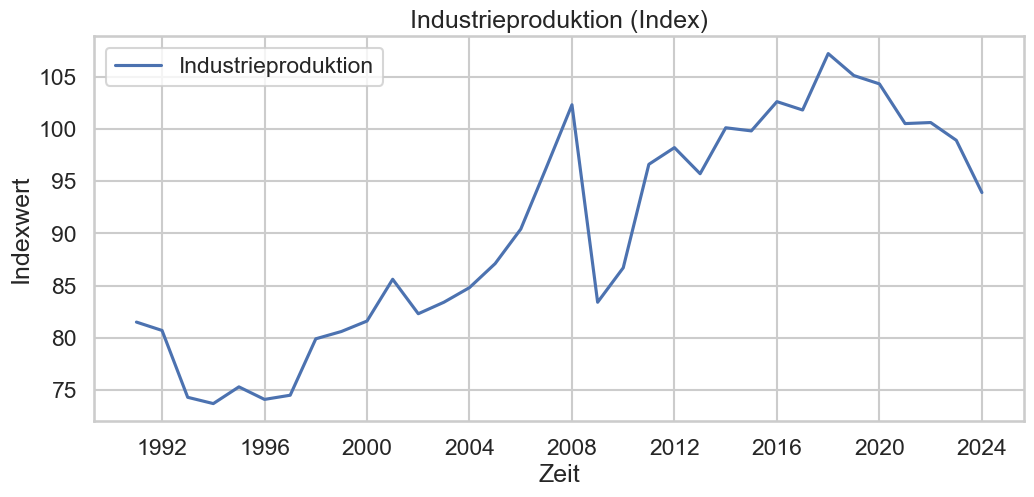

In [7]:
plt.figure(figsize=(12,5))
plt.plot(y.index, y["IP"], label="Industrieproduktion")
plt.title("Industrieproduktion (Index)")
plt.xlabel("Zeit")
plt.ylabel("Indexwert")
plt.legend()
plt.show()


### Anteil der Zeitreihen mit Missing Values overall

In [24]:
import pandas as pd

# Load long panel
panel = pd.read_csv("../data/processed/ifo_panel.csv", parse_dates=["date"])

first_date = panel["date"].min()
last_date  = panel["date"].max()

# Values at first and last date
first_vals = (
    panel.query("date == @first_date")
    .set_index(["branch","indicator","additional_info"])["value"]
)
last_vals = (
    panel.query("date == @last_date")
    .set_index(["branch","indicator","additional_info"])["value"]
)

# Helper: classify one series
def classify_series(s: pd.Series):
    mask = s.notna()
    if mask.sum() == 0:
        return "Empty"  # edge case, will be dropped later

    first_valid = mask.idxmax()
    last_valid  = mask[::-1].idxmax()
    has_internal = not mask.loc[first_valid:last_valid].all()

    start_missing = pd.isna(first_vals.loc[s.name])
    end_missing   = pd.isna(last_vals.loc[s.name])

    if has_internal and not start_missing and not end_missing:
        return "Missing_in_Middle"
    if start_missing and not end_missing and not has_internal:
        return "Only_Start_Missing"
    if end_missing and not start_missing and not has_internal:
        return "Only_End_Missing"
    if has_internal:
        return "Only_Middle_Missing"
    if start_missing and end_missing and not has_internal:
        return "Only_Start_and_End_Missing"
    return "Complete"

# Apply classification
classes = (
    panel.groupby(["branch","indicator","additional_info"])["value"]
    .apply(classify_series)
)

# Keep only the 6 categories you want
categories = [
    "Complete",
    "Only_Start_Missing",
    "Only_End_Missing",
    "Only_Start_and_End_Missing",
    "Missing_in_Middle",
    "Only_Middle_Missing"
]

summary = (
    classes.value_counts()
    .reindex(categories, fill_value=0)
    .rename("Count")
    .to_frame()
)
summary["Share_%"] = (summary["Count"] / len(classes) * 100).round(1)

print(summary)


                            Count  Share_%
value                                     
Complete                     2160     81.4
Only_Start_Missing            435     16.4
Only_End_Missing               49      1.8
Only_Start_and_End_Missing     10      0.4
Missing_in_Middle               0      0.0
Only_Middle_Missing             0      0.0
Start+Other_Missing             0      0.0
End+Other_Missing               0      0.0
Empty                           0      0.0


### Anteil der Zeitreihen mit Missing Values  nach Branche
->darstellung so noch nicht so richtig sinnvoll

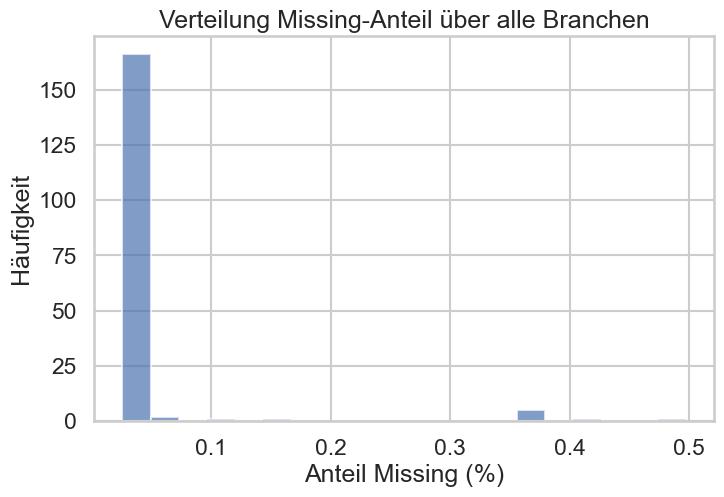

In [25]:
missing_by_branch = (
    panel.groupby(["branch"])["value"]
    .apply(lambda s: s.isna().mean())
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
missing_by_branch.plot(kind="hist", bins=20, alpha=0.7)
plt.xlabel("Anteil Missing (%)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung Missing-Anteil über alle Branchen")
plt.show()



### Anteil der Zeitreihen mit Missing Values Nach Indikator

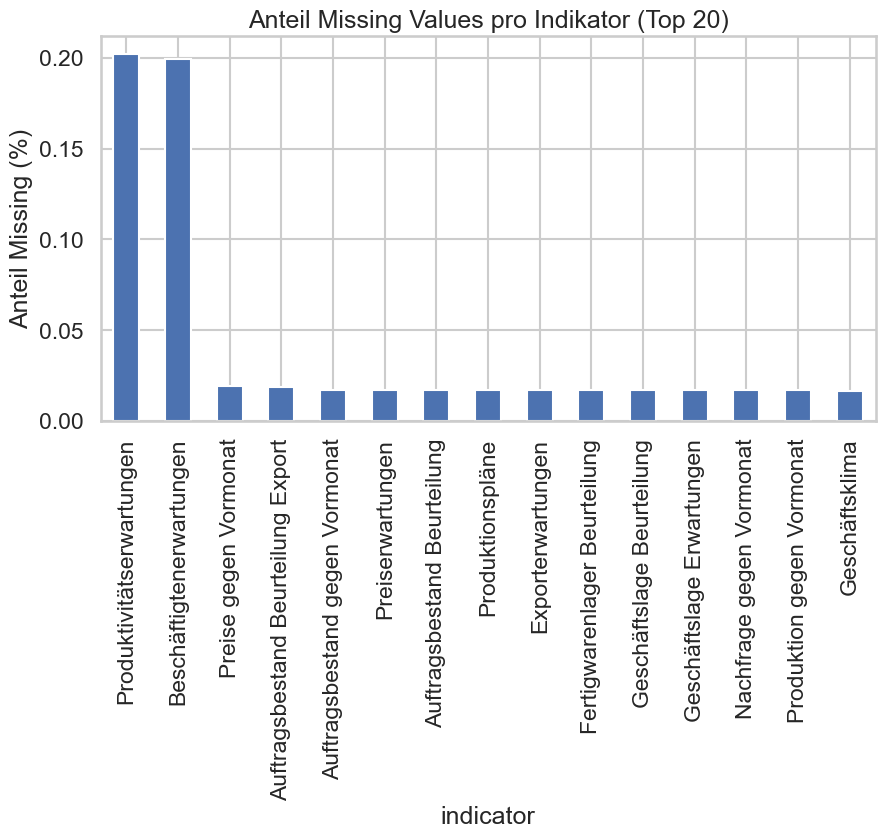

In [10]:
missing_by_indicator = (
    panel.groupby(["indicator"])["value"]
    .apply(lambda s: s.isna().mean())
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
missing_by_indicator.head(20).plot(kind="bar")  # nur Top 20
plt.ylabel("Anteil Missing (%)")
plt.title("Anteil Missing Values pro Indikator (Top 20)")
plt.show()


### Industrieproduktion & Geschäftsklima in einem Plot

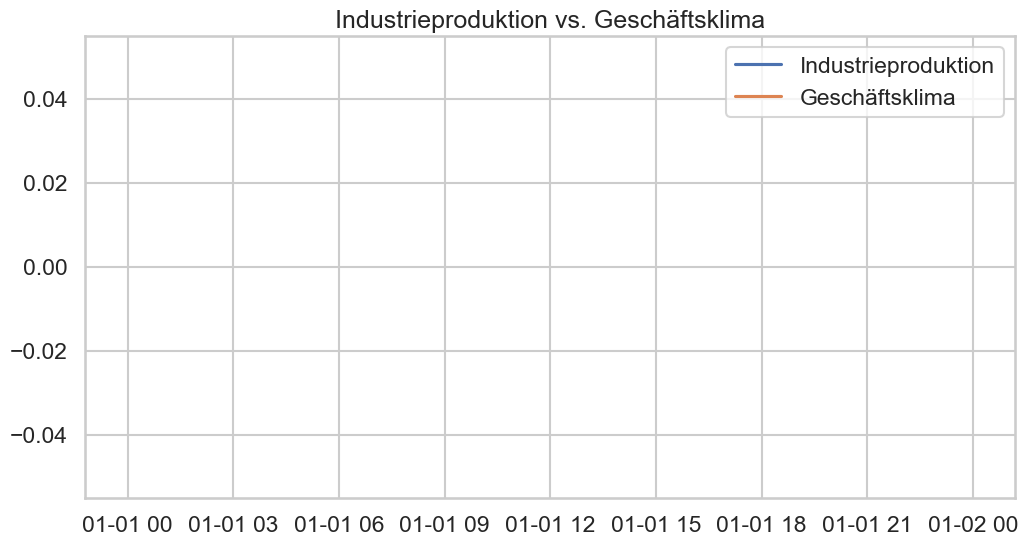

Korrelation (IP vs. Geschäftsklima): nan


In [11]:
# Geschäftsklima-Gesamtwirtschaft (Saldo oder Diffusionsindex)
climate = (
    panel
    .query("indicator.str.contains('Geschäftsklima')", engine="python")
    .query("branch == 'Verarbeitendes Gewerbe insgesamt'")
    .sort_values("date")
    [["date","value"]]
    .dropna()
    .set_index("date")
)

# Merge mit IP
df_compare = y.join(climate.rename(columns={"value":"Geschäftsklima"}), how="inner")

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_compare.index, df_compare["IP"], label="Industrieproduktion")
plt.plot(df_compare.index, df_compare["Geschäftsklima"], label="Geschäftsklima")
plt.legend()
plt.title("Industrieproduktion vs. Geschäftsklima")
plt.show()

# Korrelation
corr = df_compare.corr().iloc[0,1]
print(f"Korrelation (IP vs. Geschäftsklima): {corr:.3f}")


In [12]:
df_compare

,IP,Geschäftsklima
date,,
